In [ ]:
!nvidia-smi

Tue Apr 15 11:05:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Step 1: Write CUDA code to a file
code = r'''
#include <stdio.h>
#include <cuda_runtime.h>
#include <chrono>
#include <fstream>

// Kernel for matrix transpose
__global__ void mat_transpose(float *A, float *C, int width) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;  // Column
    int j = threadIdx.y + blockIdx.y * blockDim.y;  // Row

    if (i < width && j < width) {
        C[i * width + j] = A[j * width + i];  // Transpose operation
    }
}

// GPU function for transpose matrix
void transpose_matrix_gpu(float* h_A, float* h_C, int width, std::ofstream& log_file) {
    float *d_A, *d_C;
    size_t size = width * width * sizeof(float);

    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_C, size);
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((width + block.x - 1) / block.x, (width + block.y - 1) / block.y);

    auto start = std::chrono::high_resolution_clock::now();
    mat_transpose<<<grid, block>>>(d_A, d_C, width);
    cudaDeviceSynchronize();
    auto end = std::chrono::high_resolution_clock::now();

    std::chrono::duration<double, std::milli> duration = end - start;
    log_file << "GPU," << width << "," << duration.count() << std::endl;

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaFree(d_A);
    cudaFree(d_C);
}

// CPU function for transpose matrix
void transpose_matrix_cpu(float* A, float* C, int width, std::ofstream& log_file) {
    auto start = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < width; i++) {
        for (int j = 0; j < width; j++) {
            C[i * width + j] = A[j * width + i];
        }
    }
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double, std::milli> duration = end - start;
    log_file << "CPU," << width << "," << duration.count() << std::endl;
}

int main() {
    const int sizes[] = {128, 256, 512, 1024, 2048};
    std::ofstream log_file("transpose_performance.csv");
    log_file << "Mode,Matrix_Size,Time(ms)" << std::endl;

    for (int s = 0; s < 5; s++) {
        int width = sizes[s];
        size_t size = width * width * sizeof(float);

        float* h_A = (float*)malloc(size);
        float* h_C = (float*)malloc(size);
        float* h_C_cpu = (float*)malloc(size);

        for (int i = 0; i < width * width; i++) {
            h_A[i] = static_cast<float>(i);
        }

        transpose_matrix_cpu(h_A, h_C_cpu, width, log_file);
        transpose_matrix_gpu(h_A, h_C, width, log_file);

        free(h_A);
        free(h_C);
        free(h_C_cpu);
    }

    log_file.close();
    return 0;
}


'''

# Step 2: Save to file
with open('script.cu', 'w') as f:
    f.write(code)

# Step 3: Compile using nvcc
# Ref: https://stackoverflow.com/questions/73361454/i-am-getting-zeros-as-a-result-of-vector-additon-in-cuda-and-no-errors
!nvcc -arch=sm_75 script.cu -o script

# Step 4: Run the binary
!./script


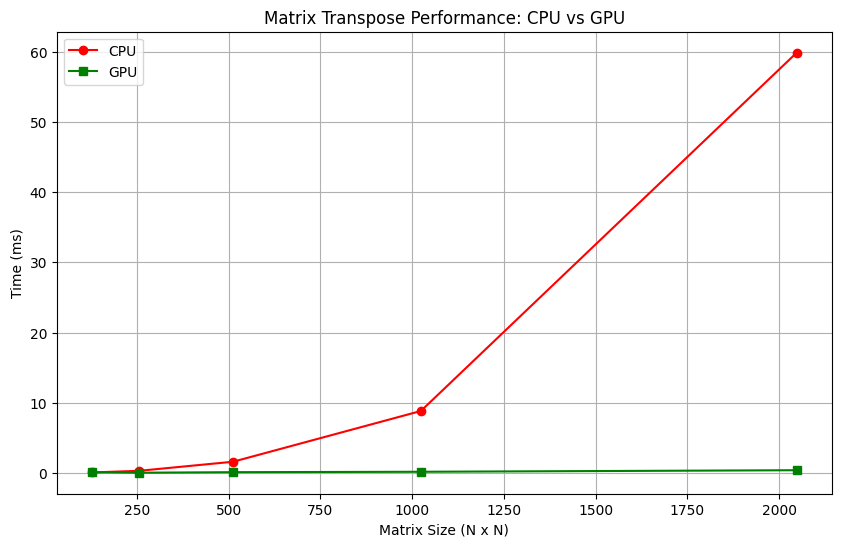

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Read the CSV file
data = pd.read_csv('transpose_performance.csv')

# Step 4: Separate the data for CPU and GPU
cpu_data = data[data['Mode'] == 'CPU']
gpu_data = data[data['Mode'] == 'GPU']

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cpu_data['Matrix_Size'], cpu_data['Time(ms)'], marker='o', label='CPU', color='r')
plt.plot(gpu_data['Matrix_Size'], gpu_data['Time(ms)'], marker='s', label='GPU', color='g')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Time (ms)')
plt.title('Matrix Transpose Performance: CPU vs GPU')
plt.legend()
plt.grid(True)
plt.show()